Load data from yahoo finance

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 15.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=aa4d3f2e9c9826620d52570b8b563875cd39ec4d8720a80ed5f971cc2308b81e
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf

In [5]:
#SP500
# ticker '000001.SS'
SP500=yf.download('^GSPC','2010-01-05',end='2021-01-05')
SP500=SP500.reset_index()
SP500.shape


[*********************100%***********************]  1 of 1 completed


(2769, 7)

Date        Open         High         Low          Close        Adj Close    Volume    
2021-01-04  3764.610107  3769.989990  3662.709961  3700.649902  3700.649902  5006680000    1
2013-08-28  1630.250000  1641.180054  1627.469971  1634.959961  1634.959961  2784010000    1
2013-09-10  1675.109985  1684.089966  1675.109985  1683.989990  1683.989990  3691800000    1
2013-09-09  1656.849976  1672.400024  1656.849976  1671.709961  1671.709961  3102780000    1
2013-09-06  1657.439941  1664.829956  1640.619995  1655.170044  1655.170044  3123880000    1
                                                                                          ..
2017-05-03  2386.500000  2389.820068  2379.750000  2388.129883  2388.129883  3893990000    1
2017-05-02  2391.050049  2392.929932  2385.820068  2391.169922  2391.169922  3813680000    1
2017-05-01  2388.500000  2394.489990  2384.830078  2388.330078  2388.330078  3199240000    1
2017-04-28  2393.679932  2393.679932  2382.360107  2384.199951  2384.199951

In [6]:
SP500.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
1,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
3,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000
4,2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000


In [7]:
SP500['Close'].shift(1).rolling( window=5,min_periods=1).mean().fillna(SP500['Close'][0])

0       1136.520020
1       1136.520020
2       1136.830017
3       1138.449992
4       1140.082489
           ...     
2764    3696.931982
2765    3702.122021
2766    3708.546045
2767    3717.502051
2768    3730.714063
Name: Close, Length: 2769, dtype: float64

In [8]:
#(SSE['Close'].shift(1)/5+SSE['Close'].shift(2)/5+SSE['Close'].shift(3)/5+SSE['Close'].shift(4)/5+SSE['Close']/5)
SP500['MA5_close']=SP500['Close'].rolling( window=5,min_periods=1).mean()
SP500['STD5_close']=SP500['Close'].rolling( window=5,min_periods=1).std()
# SP500['MA5_close']=SP500['Close'].shift(1).rolling( window=5,min_periods=1).mean().fillna(SP500['Close'][0])
# SP500['STD5_close']=SP500['Close'].shift(1).rolling( window=5,min_periods=1).std().fillna(SP500['Close'].std())


In [9]:
#fill nan
SP500['STD5_close'][0]=SP500['STD5_close'].mean()
SP500.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA5_close,STD5_close
0,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,1136.520020,16.439120
1,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,1136.830017,0.438403
2,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,1138.449992,2.822951
3,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,1140.082489,3.996610
4,2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,1141.461987,4.636243


In [10]:
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader

class StockDataset(Dataset):

    def __init__(self, data, seq_len=5):

        super(StockDataset, self).__init__()

        self.names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']
        #self.dfs = [pd.read_csv(file, sep='\t', names=self.names) for file in files]
        self.data=data
        self.length = len(data) - seq_len
        self.seq_len = seq_len

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
       

        new_idx = idx if idx < self.length else self.length-1
        
        data, target = self.generate_batch(self.data, self.seq_len, start_from=new_idx, batch_size=1)

        data = torch.from_numpy(data).type(torch.FloatTensor).squeeze()
        target = torch.from_numpy(target).type(torch.FloatTensor).squeeze()

        return data, target
    
    def count_number_of_samples(self, filepath, n_features):
        df = pd.read_csv(filepath)
        return len(df) - n_features - 1

    def generate_batch(self, dataframe, seq_len, start_from, batch_size):

        data = []
        target = []

        bs = min(batch_size, len(dataframe) - start_from)

        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
        df = dataframe.sort_values('Date').drop('Date', axis=1)
        # next create ma5 and normaliosation !!!
        for column in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','MA5_close','STD5_close']:
          #shifted MA5
          df[column]=(df[column]-df[column].rolling(window=5,min_periods=1).mean())/df[column].rolling(window=5,min_periods=1).std().fillna(1)
        for i in range(bs):
            tar = df['Close'][start_from + seq_len + i]
           
            data_row = df[start_from + i:start_from + seq_len + i].values
            
            target.append(tar)
            data.append(data_row)

        target = np.array(target).ravel()
        data = np.vstack([elem[None, ...] for elem in data])
        
       
        assert data.shape == (bs, seq_len, df.values.shape[1])
        

        assert target.shape == (bs,)

        return data, target

In [12]:
#  SSE (2670, 7)
bs=100 # batch size
horizon=5
#Divide into train and validation dataset
train_dataset=StockDataset(SP500[:2000])
val_dataset=StockDataset(SP500[2000:])

#creating dataloader 
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [13]:
SP500.shape

(2769, 9)

In [14]:
for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break

torch.Size([100, 5, 8])
torch.Size([100])


Models Generator and Discriminator

In [15]:
class Generator(nn.Module):
    def __init__(self,input_size=7, hidden_size=horizon):
        super().__init__()
        # input size: (seq_len, batch, input_size)
        #output of shape (seq_len, batch, num_directions * hidden_size):
        self.lstm=nn.LSTM(input_size=input_size,hidden_size=1,num_layers=1)
        #[bs,horizon,7]
        self.fulcon=nn.Sequential(nn.Linear(hidden_size,1,bias=True), nn.LeakyReLU(),nn.Dropout())
    def forward(self, input_seq):
        bs, seq_len=input_seq.shape[0], input_seq.shape[1]
        input_seq=input_seq.permute(1,0,2)
        out,_=self.lstm(input_seq)
        out=out.permute(1,0,2)
       
        out=out.reshape(bs,seq_len)
        y=self.fulcon(out)
        #[bs,1]
        return y

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
horizon=5 #predict for 5 days
generator=Generator(input_size=8, hidden_size=horizon)
bs=100
N_epochs=10
criteria=nn.BCEWithLogitsLoss()
Discriminator=nn.Sequential(
    nn.Linear(horizon+1,72,bias=True),
    nn.LeakyReLU(),
    nn.Linear(72,100,bias=True),
    nn.LeakyReLU(),
    nn.Linear(100,10,bias=True),
    nn.LeakyReLU(),
    nn.Linear(10,1,bias=True),
    #nn.Sigmoid()
    
)
Discriminator=Discriminator.to(device)
generator=generator.to(device)
D_opt = torch.optim.Adam(Discriminator.parameters(), lr=0.001, betas=(0.0, 0.999))
G_opt = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.0, 0.999))

#Validation
val_dataset=StockDataset(SP500[2000:])
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

Training loop

In [19]:
lambda1=0.5
lambda2=0.5

train_loss_disc=[]
train_loss_gen=[]
for epoch in range(N_epochs):
    Discriminator.train()
    generator.train()
    for itera, batch in enumerate(train_loader):
        #now target is just close price

        X_data, target = batch 
        
        X_data=X_data.to(device)
        target=target.to(device)
        #data is normalised
        bs=target.shape[0]
        #zeroes??
        fake_labels=torch.zeros([bs, 1]).to(device)
        true_labels=torch.ones([bs, 1]).to(device)
        
        gen_output=generator(X_data).detach()
        #vector of close prices 
        sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
        
        D_gen_loss=criteria(Discriminator(sequnce_6days), fake_labels)
        # index of close price is 3 
        
        true_seqeunce=torch.cat([X_data[:,:,3], target[:, None]],axis=1)
        # true_seqeunce Size is [bs, seq_len+1]
  
        D_true_loss=criteria(Discriminator(true_seqeunce), true_labels)
        
        D_loss = D_true_loss+D_gen_loss
        
        D_opt.zero_grad()
        D_loss.backward()
        D_opt.step()
        
        if itera%5:
            #let us train generator:
            gen_output=generator(X_data)
            #target is close price 
            
            # gen_output [bs,1] target [bs,] is meaned over batche items
            G_mse=torch.mean((gen_output-target[:,None])**2)
            
            sequnce_6days=torch.cat([X_data[:,:,3], gen_output], dim=1)
            
            G_logloss=-criteria(Discriminator(sequnce_6days), fake_labels)
          
            G_loss= lambda1*G_logloss + lambda2*G_mse
          
            G_opt.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        # model.eval()
        
        if itera%100:

            if itera%1000:
                print('Epoch:',epoch)
                print('train loss Discriminator',D_loss.item())
                print('train loss Generator',G_loss.item())
                
            train_loss_disc.append(D_loss.item())
            train_loss_gen.append(G_loss.item())
      
    generator.eval()
    Discriminator.eval()


    generated_seqeunce_val=[]
    target_seqeunce_val=[]
    with torch.no_grad():

      mae_test=0
      rmse_test=0
      mape_test=0
      ar_test=0
      for iter, batch in enumerate(val_loader):
          data, target=batch
          data = data.to(device)
          target = target.to(device)
          generator_output=generator(data).detach()         
          generator_output= generator_output.squeeze(0)
        
          generated_seqeunce_val.append(generator_output.item())  
          target_seqeunce_val.append(target.item()) 
          mae_test+=torch.mean(torch.abs(generator_output-target)).item()
          rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
          mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
          if iter>0:
              if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
                  ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
          
      mae_test=mae_test/len(val_loader)
      rmse_test=rmse_test/len(val_loader)
      mape_test=mape_test/len(val_loader)
      ar_test=ar_test/(len(val_loader)-1)
      print('Epoch :',epoch,', MAE val: ',mae_test)
      print('Epoch :',epoch,', RMSE val: ',rmse_test)
      print('Epoch :',epoch,', MAPE val: ',mape_test)
      print('Epoch :',epoch,', AR val: ',ar_test)

            

Epoch: 0
train loss Discriminator 1.3938308954238892
train loss Generator 0.2172316014766693
Epoch: 0
train loss Discriminator 1.3919198513031006
train loss Generator 0.05725869536399841
Epoch: 0
train loss Discriminator 1.3904352188110352
train loss Generator 0.1430959403514862
Epoch: 0
train loss Discriminator 1.3871357440948486
train loss Generator 0.3062230944633484
Epoch: 0
train loss Discriminator 1.3853607177734375
train loss Generator 0.3062230944633484
Epoch: 0
train loss Discriminator 1.3855541944503784
train loss Generator 0.18890851736068726
Epoch: 0
train loss Discriminator 1.3818283081054688
train loss Generator 0.1803586184978485
Epoch: 0
train loss Discriminator 1.3782024383544922
train loss Generator 0.2642931342124939
Epoch: 0
train loss Discriminator 1.3708484172821045
train loss Generator 0.26759713888168335
Epoch: 0
train loss Discriminator 1.3683390617370605
train loss Generator 0.26759713888168335
Epoch: 0
train loss Discriminator 1.3721942901611328
train loss Ge

Validation of the model for SSE close price

In [15]:
print('Epoch :',epoch,', MAE val: ',mae_test)
print('Epoch :',epoch,', RMSE val: ',rmse_test)
print('Epoch :',epoch,', MAPE val: ',mape_test)
print('Epoch :',epoch,', AR val: ',ar_test)

Epoch : 99 , MAE val:  0.8169731690111955
Epoch : 99 , RMSE val:  0.8169731690111955
Epoch : 99 , MAPE val:  -0.1039176072476734
Epoch : 99 , AR val:  -0.054015425107103734


In [16]:
val_dataset=StockDataset(SP500[2000:])
val_dataset.data=val_dataset.data.reset_index().drop('index',axis=1)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

generator.eval()

generated_seqeunce_val=[]
target_seqeunce_val=[]
with torch.no_grad():

  mae_test=0
  rmse_test=0
  mape_test=0
  ar_test=0
  for iter, batch in enumerate(val_loader):
      data, target=batch
      data = data.to(device)
      target = target.to(device)
      generator_output=generator(data).detach()         
      generator_output= generator_output.squeeze(0)
     
      generated_seqeunce_val.append(generator_output.item())  
      target_seqeunce_val.append(target.item()) 
      
      mae_test+=torch.mean(torch.abs(generator_output-target)).item()
      rmse_test += torch.sqrt(torch.mean((generator_output-target)**2)).item()
      mape_test+=torch.mean(torch.abs(generator_output-target)/(target+0.0000001)).item()
      if iter>0:
          if generated_seqeunce_val[iter]>generated_seqeunce_val[iter-1]:
              ar_test+=target_seqeunce_val[iter]-target_seqeunce_val[iter-1]
      
  mae_test=mae_test/len(val_loader)
  rmse_test=rmse_test/len(val_loader)
  mape_test=mape_test/len(val_loader)
  ar_test=ar_test/(len(val_loader)-1)
  print('MAE val: ',mae_test)
  print('RMSE val: ',rmse_test)
  print('MAPE val: ',mape_test)
  print('AR val: ',ar_test)



  #print(f'Epoch {epoch} \t Train loss {train_loss} \t Test loss {test_loss}')

MAE val:  0.8169731690111955
RMSE val:  0.8169731690111955
MAPE val:  -0.1039176072476734
AR val:  -0.054015425107103734


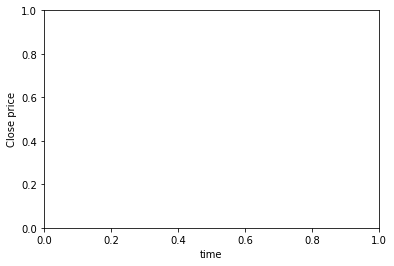

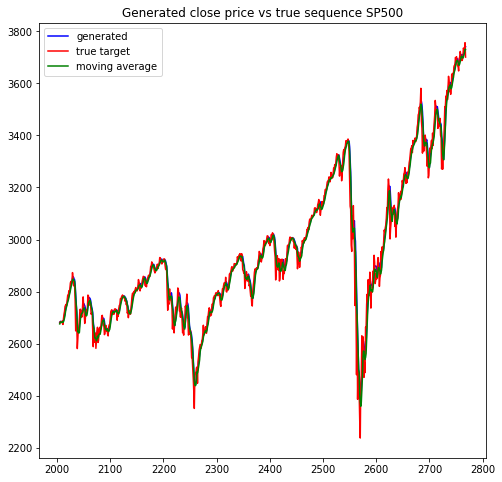

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xlabel('time')
plt.ylabel('Close price')
plt.figure(figsize=[8,8])
plt.title('Generated close price vs true sequence SP500')
plt.plot(generated_seqeunce_val*SP500.loc[2000+5:, 'STD5_close']+SP500.loc[2000+5:,'MA5_close'],label='generated',c='blue')
plt.plot(SP500.loc[2000+5:,'Close'], label='true target',c='red')
plt.plot(SP500.loc[2000+5:,'MA5_close'], label='moving average',c='green')
plt.legend()


Text(0, 0.5, 'Train Loss')

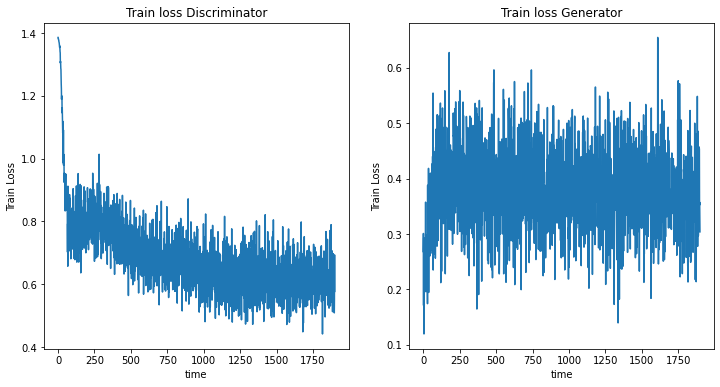

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=[12,6])

axs[0].set_title('Train loss Discriminator')
axs[0].plot(train_loss_disc)
axs[1].set_title('Train loss Generator')
axs[1].plot(train_loss_gen)

#
axs[1].set_xlabel('time')
axs[0].set_xlabel('time')
axs[0].set_ylabel('Train Loss')
axs[1].set_ylabel('Train Loss')

In [19]:
train_all = DataLoader(train_dataset, batch_size=2000, shuffle=True)


for X_all, target in train_all:
  X_all,target=X_all.to(device),target.to(device)
  gen_output=generator(X_all)
 
 

In [20]:
gen_output=gen_output.detach().cpu().numpy()

In [21]:
list(gen_output.squeeze(1))*SP500.loc[6:2000, 'STD5_close']+SP500.loc[6:2000,'MA5_close']

6       1143.104970
7       1144.459580
8       1142.826094
9       1148.982340
10      1143.679117
           ...     
1996    2639.636921
1997    2640.917250
1998    2650.641812
1999    2651.074648
2000    2659.963042
Length: 1995, dtype: float64

Text(0, 0.5, 'closing price')

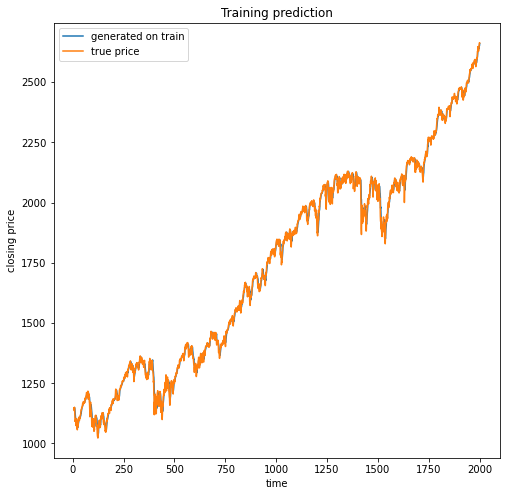

In [22]:
plt.figure(figsize=[8,8])
plt.title('Training prediction')
plt.plot(list(gen_output.squeeze(1))*SP500.loc[6:2000, 'STD5_close']+SP500.loc[6:2000,'MA5_close'] ,label='generated on train')
plt.plot(SP500.loc[6:2000,'Close'],label='true price')
plt.legend()
plt.xlabel('time')
plt.ylabel('closing price')

In [23]:

plt.plot(gen_output.detach().cpu(), label='generated x')
plt.plot(target.detach().cpu(), label='target')
plt.legend()

AttributeError: ignored

In [ ]:
plot_diff=gen_output.squeeze(1).detach().cpu().numpy()-target.detach().cpu().numpy()
plt.plot(plot_diff)

In [ ]:
plot_diff.shape

In [ ]:
plt.hist(plot_diff,bins=40)